# LSTM for word representations in human brain tutorial



## Introduction ##
Language encoding models can help us understand the underlying mechanisms of language processing in the human brain. Alexander Huth explains how he uses a 985-dimensional word embedding to model FMRI response in [this tutorial](https://github.com/HuthLab/speechmodeltutorial). This word embedding method however, uses a quite outdated method. He also has a [follow-up paper](https://papers.nips.cc/paper/7897-incorporating-context-into-language-encoding-models-for-fmri) where he uses an LSTM to train the word representations to respond to context. This notebook is an extension of his own tutorial, where we use a more advanced word embedding method, as well as showing an example implementation of the LSTM, since his own tutorial does not contain it. At the end of the tutorial you will be left with a set of models that can be used to convert a text into word embeddings using a very similar method to Huth's. 

All the libraries needed in this tutorial, WordEmbedding and StoriesDataset are two custom classes to help loading the word embeddings and the dataset. LSTMWordpred is the PyTorch architecture for the LSTM model. 

In [1]:
# configurations and imports
from nlp_fmri_utils import WordEmbedding, StoriesDataset, LSTMWordpred, load_models
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import pickle as pkl
import os
import re

# functions from Alexander Huths tutorial
import functions

modeldir = './models'
seqdir = './seq_data'
gridsdir = './grids'
trdir = './trfiles'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.device)

<class 'torch.device'>


The below cell will check if you have the proper datafiles, if not it will download them for you.

In [2]:
# run this to download the datafiles from the web
import requests
import zipfile

if not os.path.exists("stories.csv"): 
    r1 = requests.get('https://www.kaggle.com/shubchat/1002-short-stories-from-project-guttenberg/download', allow_redirects=True)
    open('stories.csv', 'wb').write(r1.content)

if not os.path.exists("glove_embeds.txt"): 
    r2 = requests.get('http://nlp.stanford.edu/data/glove.6B.zip', allow_redirects=True)
    open('glove.6B.zip', 'wb').write(r2.content)
    
    with zipfile.ZipFile('glove.6B.zip') as z:
        with open('glove_embeds.txt', 'wb') as f:
            f.write(z.read('glove.6B.300d.txt'))
    

## Part 1: the word embedding
To represent each word in the text, a pre-trained word embedding is used. The word embedding we use is a 50 dimensional GloVe embedding. We use a pre-trained word embedding because doing the embedding in this tutorial will be too time consuming. The GloVe embedding algorithm takes a sparse word co-occurrence matrix and turns it into a dense word embedding matrix. For more information on how this embedding works, check the [original paper](https://nlp.stanford.edu/projects/glove/). 

Initialize a WordEmbedding object with the path to the pre-trained embeddings, we will use this later to look at word similarities and to convert text to vectors. The pre-trained embeddings contain 40 thousand words with 50 dimensions each, so this might take a minute.  

In [3]:
glove_embeddings = WordEmbedding(f'glove_embeds.txt')

Made an embedding containing  400000 words.


We check if the embeddings have been parsed correctly by seeing if the shape is correct. The array should be of shape n_words x n_dimensions. We can also test if we can find the vector of a particular word

In [4]:
print("vector matrix shape:", glove_embeddings.vectors.shape)
test_word = 'cheese'
print(f"the word vector of the word {test_word} is: ", glove_embeddings.get_word_vectors([test_word]))

vector matrix shape: (400000, 50)
the word vector of the word cheese is:  [[-0.053903 -0.30871  -1.3285   -0.43342   0.31779   1.5224   -0.6965
  -0.037086 -0.83784   0.074107 -0.30532  -0.1783    1.2337    0.085473
   0.17362  -0.19001   0.36907   0.49454  -0.024311 -1.0535    0.5237
  -1.1489    0.95093   1.1538   -0.52286  -0.14931  -0.97614   1.3912
   0.79875  -0.72134   1.5411   -0.15928  -0.30472   1.7265    0.13124
  -0.054023 -0.74212   1.675     1.9502   -0.53274   1.1359    0.20027
   0.02245  -0.39379   1.0609    1.585     0.17889   0.43556   0.68161
   0.066202]]


Great!

Below we use [TSNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), a method to cluster and visualize high dimensional data to show words of two distinct categories:
1. food related items
2. family related items

TSNE is able to make a clear distinction between the two categories. 

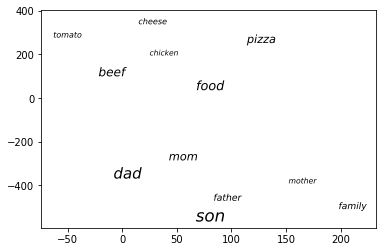

In [5]:
# plot words with tsne dimensionality reduction

words = ["mother", "mom", "dad", "father", "son", "family", "cheese", "pizza", "chicken", "tomato", "beef", "food"]
vects = glove_embeddings.get_word_vectors(words)

viz_dims = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(vects)

fig = plt.figure()
ax = fig.add_subplot(111)
i=0

for a in words:
    ax.scatter(viz_dims[i][0], viz_dims[i][1], s=800, c='black', marker=r"$ {} $".format(a), edgecolors='none' )
    i+=1

plt.show()

From the graph above we can conclude that the words within each cluster are somewhat similar, but how similar (or how different) are they exactly? We can use cosine similarity to quantify the similarity between two words, where 0 is most dissimilar and 1 is most similar. 

In [6]:
for pair in [('dad', 'mom'), 
             ('dad', 'pizza'), 
             ('pizza', 'cheese'), 
             ('fruit', 'rock'), 
             ('man', 'woman'),
             ('food','family')
             ]:
    
    print('Similarity between {} and {} is: {}'.
          format(pair[0], pair[1], glove_embeddings.similarity(pair[0], pair[1])))

Similarity between dad and mom is: 0.9040323212958359
Similarity between dad and pizza is: 0.3952750348424894
Similarity between pizza and cheese is: 0.7087556782372948
Similarity between fruit and rock is: 0.328926165386697
Similarity between man and woman is: 0.8860337718495819
Similarity between food and family is: 0.5078556142593991


We can also go a step further and find the 5 most similar words from a given word, lets try some. Use the most_similar function.

In [7]:
for word in ['soldier',
             'king',
             'food',
             'rock',
             'family'
            ]:
    
    print('The words most similar to {} are: {}'.format(word, glove_embeddings.most_similar(word, 5)))

The words most similar to soldier are: ['wounded', 'killed', 'soldiers', 'army', 'troops']
The words most similar to king are: ['emperor', 'throne', 'son', 'lord', 'prince']
The words most similar to food are: ['products', 'vegetables', 'meat', 'medicines', 'goods']
The words most similar to rock are: ['band', 'album', 'music', 'songs', 'albums']
The words most similar to family are: ['816-822-8448', 'mother', 'daughter', 'wife', 'son']


Another interesting emergence from these word embeddings is word analogies, for example a man is to a king what a woman is to a ?. The function takes the vector of a word, like "man", subtracts another vector, like "king", and then adds a third vector, like "queen". Then finds the nearest word to the resulting vector. We can try some word analogy triplets with the analogy function.

In [8]:
triplets = [('king', 'man', 'queen'),
            ('university', 'professor', 'school'),
            ('mother', 'daughter', 'father'),
            ('god', 'church', 'devil'),
           ]

for a, b, c in triplets:
    print('{} is to {} as {} is to {}'.format(a, b, c, glove_embeddings.analogy(a, b, c, 5)))

king is to man as queen is to ['woman', 'girl', 'her', 'man', 'she']
university is to professor as school is to ['school', '816-822-8448', 'professor', 'college', 'teacher']
mother is to daughter as father is to ['son', 'daughter', 'father', 'married', 'wife']
god is to church as devil is to ['non-institutionalized', 'church', 'st.', 'cathedral', '732-390-4697']


The analogy task is not performing perfectly, but the results are in the ballpark of what we could expect. Its clear that these word embeddings contain a lot of information, while only having 50 dimensions per word.

## Part 2: data preparation

The texts used by Alexander Huth are short stories, so it only makes sense for us to use other short stories as training data for the LSTM. The texts we will use are from [PROJECT GUTENBERG](https://www.gutenberg.org/), it's a dataset with 1000 short stories. 

The StoriesDataset class will load the processed datafile if it exists, if not it must be generated first by using generate_sequences. If you dont have processed .csv files yet, run the cell below to create a processed dataset containing n stories. For the sake of this tutorial, 10 stories should be enough. 

The preprocessing the generate_sequences function does is the following:
1. remove all non-word tokens and large whitespaces.
2. lowercase all words.
3. generate sequences of length n, with targets. 

The sequences will use the sliding window principle, with the last word being the target. 

Alexander Huths second paper uses 10 different context lengths to see if different parts of the brain react to which context length. For simplicity we will only use 3 context lengths, 5, 10 and 15. For this we must generate 3 separate datasets. 

In [9]:
# run this to generate sequences first if you havent already
context_lens = [5, 10, 15]
n_stories = 3

if not os.path.exists(seqdir):
    os.mkdir(seqdir)

for context_len in context_lens:
    filename = 'seq_{}.csv'.format(context_len)
    StoriesDataset(os.path.join(seqdir, filename) , glove_embeddings).generate_sequences('stories.csv', 'content', n_stories, context_len)

## Part 3: training the LSTM

Now that we have prepared the sequences and the targets, we can start training an LSTM model! The input of the model will be the word embeddings of a single sequence, the target output will be the index of the target word. 

The model will have the following layers:
2. The first lstm layer, with an input shape of maximum sequence length * the word embedding size.
3. The second lstm layer.
4. The third lstm layer. 
5. A dense layer that with one output node for each unique word in the text, using a sigmoid activation.  

The architecture of the model has already been made in PyTorch, we only have to call it and give it the right arguments, 3 LSTM layers of size 50.

We will use cosine similarity (called CosineEmbeddingLoss in PyTorch) as loss function and adam as optimizer. We also have to retrieve the datasets we made earlier. 

In [10]:
loss_fun = torch.nn.MSELoss()

fit_params = {'n_epochs': 3,
              'val_split': 0.1,
              'batch_size': 10,
              'loss_function': loss_fun}

model_params = {'hidden_dim': 50,
                'n_layers': 3,
                'embedding_dim': glove_embeddings.dim}

lr = 0.001

Dont forget that we have to make 3 models, one for each context length. Running the following cell will fit a model using the hyperparameters above for each context length we have available and save the model as a pickle file. 

Running this cell can take a long time if you dont have a strong GPU available for PyTorch to use. Luckily, I trained some models and saved them, if you dont want to wait for the training loop, use the pretrained models instead.

In [11]:
if not os.path.exists(modeldir):
    os.mkdir(modeldir)

for filename in os.listdir(seqdir):
    if filename.endswith(".csv"):
        print(f'Making model for {filename}...')
        model = LSTMWordpred(**model_params)
        adam = optim.Adam(model.parameters(), lr=lr)

        print(filename)
        ds = StoriesDataset(os.path.join(seqdir, filename), glove_embeddings)
        
        cl = re.search('seq_(.+?).csv', filename).group(1)
        
        train_hist, val_hist = model.fit(ds, opt=adam, **fit_params)
        filename = f'lstm_model{cl}.pth'
        
        torch.save(model.state_dict(), os.path.join(modeldir, filename))
        
        # add your code for loss history visualization here.
        
        continue

Making model for seq_15.csv...
seq_15.csv
Fitting model with 3 epochs over 57495 sequences.
Starting epoch 1


TypeError: forward() takes 3 positional arguments but 4 were given

The following cell will load the pretrained models in a dictionary.

In [ ]:
model_arch = LSTMWordpred(**model_params)

models = load_models(model_arch, modeldir)

To make the new representations we need a replacement for the make_semantic_model function used by Huth, this function is the one below. This repo does not contain the Datasequence class that the original paper uses, so it will give an error when you run it.

In [ ]:
# new function to make the semantic model
from functions import DataSequence
def make_semantic_lstm_model(ds, embeddings, lstm_model, layer, seq_len):
    x = []
    words = ds.data
    for i in range(0, len(words), 1):
        if i <= seq_len:
            seq = list(seq_len*' ')
        else:
            seq = words[i-seq_len:i]
        
        seq_emb = embeddings.get_word_vectors(seq)
        x.append(seq_emb)
    seqs = torch.from_numpy(np.stack(x)).float()
    representations = lstm_model.get_hidden_states(seqs)[layer-1].detach().numpy()
    
    return DataSequence(representations, ds.split_inds, ds.data_times, ds.tr_times)

And thats it. To use the LSTM for word representations instead of the Eng1000 representation, you will have to make the following adjustments to the original tutorial:

1. load the glove word embeddings (cell 3).
2. load the pretrained models (cell 10 and 11).
3. copy the new semantic model function (cell 13).
4. use the lstm semantic model function instead of the original function.

The files and directories you will need are:
1. A models folder with the pretrained models.
2. The word embeddings .txt file.
3. The nlp_utils.py file

I might improve on this explanation by uploading the modified tutorial, or a more detailed walkthrough. But for now, this will have to do.

# THE NEXT PART IS COPIED FROM HUTHS TUTORIAL

In [ ]:
# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy',
            'life', 'myfirstdaywiththeyankees', 'naked',
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from functions import load_grids_for_stories
grids = load_grids_for_stories(allstories, gridsdir)

# Load TRfiles
from functions import load_generic_trfiles
trfiles = load_generic_trfiles(allstories, trdir)

# Make word and phoneme datasequences
from functions import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}


In [ ]:
# Project stimuli
from functions import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_lstm_model(wordseqs[story], glove_embeddings, models['lstm_model10'], 2, 5)

In [ ]:
test = semanticseqs['naked'].data.shape

In [ ]:
# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)

In [ ]:
# Plot the result
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

plt.plot(s_sem.data[10,:])
plt.plot(s_sem.data[21,:])
plt.plot(s_sem.data[32,:])
plt.plot(s_sem.data[43,:])
plt.plot(s_sem.data[74,:])

print(s_sem.data[:,10].std())
print(s_sem.data[:,10].mean())
print(s_semdown.data.shape)

In [ ]:
f = plt.figure(figsize=(15,5), facecolor='w')
f.clf()
schan = 6
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times,
                    s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(),
                    linefmt="k-", markerfmt="k.", basefmt="k-", use_line_collection=True)
interps = ax.plot(s_sem.tr_times,
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"))